# On Multiple Linear Regression - Codealong

*Note: `scikit-learn` version 0.21.2 contains a necessary revision to [use the `drop` parameter within `OneHotEncoder`](https://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing). Please reinstall your version of `scikit-learn` with the latest version (as of July 5, 2019)*

In [ ]:
!pip install 'scikit-learn==0.21.2' --force-reinstall

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

The main idea here is pretty simple. Whereas, in simple linear regression we took our dependent variable to be a function only of a single independent variable, here we'll be taking the dependent variable to be a function of multiple independent variables.

Our regression equation, then, instead of looking like $\hat{y} = mx + b$, will now look like:

$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1x_1 + ... + \hat{\beta}_nx_n$.

Remember that the hats ( $\hat{}$ ) indicate parameters that are estimated.

## Dealing with Categorical Variables

One issue we'd like to resolve is what to do with categorical variables, i.e. variables that represent categories rather than continua. In a Pandas DataFrame, these columns may well have strings or objects for values, but they need not. Recall e.g. the heart-disease dataset from Kaggle in which the target variable took values 0-4, each representing a different stage of heart disease.

### Dummying

One very effective way of dealing with categorical variables is to dummy them out. What this involves is making a new column for _each categorical value in the column we're dummying out_. We'll do this below in our air safety dataset where we have a column of airline names.

These new columns will be filled only with 0's and 1's, a 1 representing the presence of the relevant categorical value.

Let's look at a simple example:

In [29]:
instructor_data = [{"name": "Brian", "home_state": "CT"},
                   {"name": "Miles", "home_state": "WA"},
                   {"name": "Cristian", "home_state": "IL"},
                   {"name": "Kena", "home_state": "TX"}]

In [30]:
instructor_df = pd.DataFrame(instructor_data)
instructor_df

,home_state,name
0,CT,Brian
1,WA,Miles
2,IL,Cristian
3,TX,Kena


> `OneHotEncoder` transforms each categorical feature with `n_categories` possible values into `n_categories` binary features, with one of them 1, and all others 0. - [`sklearn.preprocessing` user guide](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features)

In [31]:
categorical = instructor_df["home_state"].values.reshape(-1, 1)
categorical

array([['CT'],
       ['WA'],
       ['IL'],
       ['TX']], dtype=object)

In [32]:
encoder = OneHotEncoder(drop="first", categories="auto")

encoder.fit(categorical)

OneHotEncoder(categorical_features=None, categories='auto', drop='first',
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

These are the categories we fed into the encoder object.

In [33]:
encoder.categories_

[array(['CT', 'IL', 'TX', 'WA'], dtype=object)]

In [34]:
print(f"""
Without a prefix, the feature names look like this: 
{encoder.get_feature_names()}
      
*******

With a prefix, they look like this: 
{encoder.get_feature_names(['home_state'])}
""")


Without a prefix, the feature names look like this: 
['x0_IL' 'x0_TX' 'x0_WA']
      
*******

With a prefix, they look like this: 
['home_state_IL' 'home_state_TX' 'home_state_WA']



In [35]:
ohe = pd.DataFrame(encoder.transform(categorical).toarray(),
                   columns=encoder.get_feature_names(["home_state"]))

ohe.head()

,home_state_IL,home_state_TX,home_state_WA
0,0.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0


Where did the `home_state_CT` feature go?

## Drug Use Dataset

In [53]:
drugs = pd.read_csv('raw_data/drug-use-by-age.csv')

In [54]:
drugs.head()

,age,n,alcohol-use,alcohol-frequency,marijuana-use,marijuana-frequency,cocaine-use,cocaine-frequency,crack-use,crack-frequency,...,oxycontin-use,oxycontin-frequency,tranquilizer-use,tranquilizer-frequency,stimulant-use,stimulant-frequency,meth-use,meth-frequency,sedative-use,sedative-frequency
0,12,2798,3.9,3.0,1.1,4.0,0.1,5.0,0.0,-,...,0.1,24.5,0.2,52.0,0.2,2.0,0.0,-,0.2,13.0
1,13,2757,8.5,6.0,3.4,15.0,0.1,1.0,0.0,3.0,...,0.1,41.0,0.3,25.5,0.3,4.0,0.1,5.0,0.1,19.0
2,14,2792,18.1,5.0,8.7,24.0,0.1,5.5,0.0,-,...,0.4,4.5,0.9,5.0,0.8,12.0,0.1,24.0,0.2,16.5
3,15,2956,29.2,6.0,14.5,25.0,0.5,4.0,0.1,9.5,...,0.8,3.0,2.0,4.5,1.5,6.0,0.3,10.5,0.4,30.0
4,16,3058,40.1,10.0,22.5,30.0,1.0,7.0,0.0,1.0,...,1.1,4.0,2.4,11.0,1.8,9.5,0.3,36.0,0.2,3.0


In [55]:
drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 28 columns):
age                        17 non-null object
n                          17 non-null int64
alcohol-use                17 non-null float64
alcohol-frequency          17 non-null float64
marijuana-use              17 non-null float64
marijuana-frequency        17 non-null float64
cocaine-use                17 non-null float64
cocaine-frequency          17 non-null object
crack-use                  17 non-null float64
crack-frequency            17 non-null object
heroin-use                 17 non-null float64
heroin-frequency           17 non-null object
hallucinogen-use           17 non-null float64
hallucinogen-frequency     17 non-null float64
inhalant-use               17 non-null float64
inhalant-frequency         17 non-null object
pain-releiver-use          17 non-null float64
pain-releiver-frequency    17 non-null float64
oxycontin-use              17 non-null float64
oxycontin-f

In [56]:
drugs['age'] = drugs['age'].map(int)

ValueError: invalid literal for int() with base 10: '22-23'

What happened?

In [57]:
drugs['age'].value_counts()

24-25    1
18       1
26-29    1
14       1
30-34    1
65+      1
17       1
22-23    1
15       1
19       1
16       1
21       1
35-49    1
13       1
50-64    1
12       1
20       1
Name: age, dtype: int64

In [41]:
# Let's take a closer look at this 'age' column:

drugs['age'][:15]

0        12
1        13
2        14
3        15
4        16
5        17
6        18
7        19
8        20
9        21
10    22-23
11    24-25
12    26-29
13    30-34
14    35-49
Name: age, dtype: object

In [58]:
drugs["age"] = drugs["age"].str[:2].astype(int)

In [43]:
drugs['age'][:15]

0     12
1     13
2     14
3     15
4     16
5     17
6     18
7     19
8     20
9     21
10    22
11    24
12    26
13    30
14    35
Name: age, dtype: int64

In [59]:
drugs.head().T

,0,1,2,3,4
age,12,13,14,15,16
n,2798,2757,2792,2956,3058
alcohol-use,3.9,8.5,18.1,29.2,40.1
alcohol-frequency,3,6,5,6,10
marijuana-use,1.1,3.4,8.7,14.5,22.5
marijuana-frequency,4,15,24,25,30
cocaine-use,0.1,0.1,0.1,0.5,1
cocaine-frequency,5.0,1.0,5.5,4.0,7.0
crack-use,0,0,0,0.1,0
crack-frequency,-,3.0,-,9.5,1.0


## Model Selection

Let's imagine that I'm going to try to predict age based on factors to do with drug use.

Now: Which columns (predictors) should I choose? Even ignoring the non-numeric categories in my dataset, there are still 20 predictors I could choose! For each of these predictors, I could either use it or not use it in my model, which means that there are 2^20 = 1,048,576 different models I could construct! Well, okay, one of these is the "empty model" with no predictors in it. But there are still 1,048,575 models from which I can choose!

How can I decide which predictors to use in my model?

### Correlation

In [60]:
# Use the .corr() DataFrame method to find out about the
# correlation values between all pairs of variables!

drugs.corr()

,age,n,alcohol-use,alcohol-frequency,marijuana-use,marijuana-frequency,cocaine-use,crack-use,heroin-use,hallucinogen-use,...,pain-releiver-use,pain-releiver-frequency,oxycontin-use,tranquilizer-use,tranquilizer-frequency,stimulant-use,stimulant-frequency,meth-use,sedative-use,sedative-frequency
age,1.000000,0.209636,0.347178,0.629531,-0.365037,0.296227,-0.179095,0.106592,-0.184835,-0.387573,...,-0.429406,0.186960,-0.371449,-0.250137,-0.316679,-0.382329,0.778792,-0.261252,-0.394353,0.396722
n,0.209636,1.000000,0.310512,0.313431,-0.169007,0.135597,-0.021565,0.281797,0.007798,-0.295302,...,-0.083587,-0.112076,-0.166039,-0.071086,-0.102301,-0.201621,-0.114792,-0.063571,-0.119997,0.256701
alcohol-use,0.347178,0.310512,1.000000,0.897889,0.594165,0.920425,0.773458,0.877378,0.677614,0.463702,...,0.617523,-0.263721,0.589219,0.735785,-0.550501,0.582241,-0.028115,0.682531,0.318268,0.091251
alcohol-frequency,0.629531,0.313431,0.897889,1.000000,0.260219,0.818769,0.577601,0.785050,0.546194,0.182184,...,0.280704,0.007087,0.251554,0.448543,-0.415026,0.291766,0.260304,0.425153,0.029867,0.201423
marijuana-use,-0.365037,-0.169007,0.594165,0.260219,1.000000,0.615610,0.883789,0.620670,0.711613,0.959353,...,0.966226,-0.506892,0.971733,0.935199,-0.401769,0.968096,-0.389145,0.870446,0.616766,-0.277144
marijuana-frequency,0.296227,0.135597,0.920425,0.818769,0.615610,1.000000,0.742598,0.892077,0.631789,0.528733,...,0.612254,-0.285292,0.609618,0.768339,-0.591449,0.561246,-0.069454,0.664280,0.399124,0.048777
cocaine-use,-0.179095,-0.021565,0.773458,0.577601,0.883789,0.742598,1.000000,0.835727,0.899944,0.855668,...,0.906638,-0.273908,0.865626,0.920430,-0.294905,0.923954,-0.309286,0.889353,0.461914,-0.159997
crack-use,0.106592,0.281797,0.877378,0.785050,0.620670,0.892077,0.835727,1.000000,0.750790,0.556222,...,0.652764,-0.203711,0.603003,0.772651,-0.345668,0.618008,-0.294260,0.694324,0.438421,0.091676
heroin-use,-0.184835,0.007798,0.677614,0.546194,0.711613,0.631789,0.899944,0.750790,1.000000,0.683674,...,0.805868,-0.135961,0.775321,0.818583,-0.175464,0.808024,-0.277996,0.816620,0.333649,-0.023708
hallucinogen-use,-0.387573,-0.295302,0.463702,0.182184,0.959353,0.528733,0.855668,0.556222,0.683674,1.000000,...,0.909333,-0.419961,0.916777,0.862900,-0.314281,0.940008,-0.319860,0.780071,0.518700,-0.312746


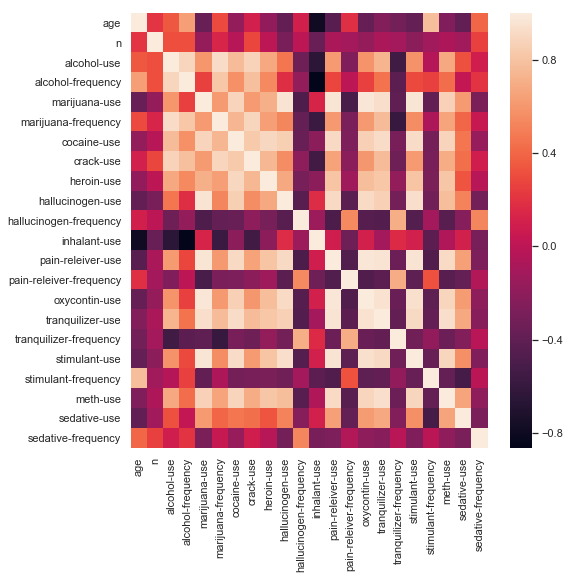

In [61]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8, 8)})

# Use the .heatmap method to depict the relationships visually!
sns.heatmap(drugs.corr())

In [62]:
# Let's look at the correlations with 'age'
# (our dependent variable) in particular.

drugs.corr()['age'].sort_values(ascending=False)

age                        1.000000
stimulant-frequency        0.778792
alcohol-frequency          0.629531
sedative-frequency         0.396722
alcohol-use                0.347178
marijuana-frequency        0.296227
n                          0.209636
pain-releiver-frequency    0.186960
crack-use                  0.106592
hallucinogen-frequency     0.099373
cocaine-use               -0.179095
heroin-use                -0.184835
tranquilizer-use          -0.250137
meth-use                  -0.261252
tranquilizer-frequency    -0.316679
marijuana-use             -0.365037
oxycontin-use             -0.371449
stimulant-use             -0.382329
hallucinogen-use          -0.387573
sedative-use              -0.394353
pain-releiver-use         -0.429406
inhalant-use              -0.784329
Name: age, dtype: float64

In [64]:
X = drugs[['alcohol-frequency', 'inhalant-use', 'stimulant-frequency']]
y = drugs['age']

### Multicollinearity

Probably 'alcohol-use' and 'alcohol-frequency' are highly correlated _with each other_ as well as with 'age'. This can lead to the production of an _overfit_ model. We'll stick a pin in this and return to the issue of overfit models soon.

## Multiple Regression in StatsModels

In [67]:
import statsmodels.api as sm

ImportError: cannot import name 'factorial' from 'scipy.misc' (/Users/jjherranzsarrion/anaconda3/lib/python3.7/site-packages/scipy/misc/__init__.py)

In [ ]:
predictors = np.asarray(X)
predictors_int = sm.add_constant(predictors)
model = sm.OLS(y, predictors_int).fit()
model.summary()

In [ ]:
predictors = np.asarray(X2)
predictors_int = sm.add_constant(X2)
model = sm.OLS(np.asarray(y), predictors_int).fit()
model.summary()

## Multiple Regression in Scikit-Learn

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [69]:
np.random.seed(33)

# Now let's split our data into train and test sets.

X_train, X_test, Y_train, Y_test = train_test_split(X, y)

In [70]:
# Let's create a StandardScaler object to scale our data for us.
ss = StandardScaler()


# Now we'll apply it to our data by using the .fit_transform() method.

ss.fit(X_train)

X_train_scaled = ss.transform(X_train)

In [71]:
# Now we can fit the LinearRegression object to our training data!

lr = LinearRegression()
lr.fit(X_train_scaled, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
# And score it on our testing set

lr.score(X_test, Y_test)

-186.30337732147484

In [73]:
# We can use the .coef_ attribute to recover the results
# of the regression.

lr.coef_

array([-1.14134056, -5.59197225,  2.11997446])

## Recursive Feature Elimination

The idea behind recursive feature elimination is to build up (or down) to a small set of predictive features slowly, by eliminating the features with the lowest coefficients.

That is:
1. Start with a model with _all_ $n$ predictors;
2. find the predictor with the smallest coefficient;
3. throw that predictor out and build a model with the remining $n-1$ predictors;
4. set $n = n-1$ and repeat until $n-1$ has the value you want!

### Recursive Feature Elimination in Scikit-Learn

In [74]:
from sklearn.feature_selection import RFE

lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=2)
select = select.fit(X = drugs.drop(columns=['age',
                                       'cocaine-frequency',
                                       'crack-frequency',
                                       'heroin-frequency',
                                       'inhalant-frequency',
                                       'oxycontin-frequency',
                                       'meth-frequency']),
                    y = drugs['age'])

select.ranking_

array([20, 18, 15,  8, 12,  7,  1,  2, 11, 13,  1,  5,  9,  3, 10, 19,  6,
       14,  4, 17, 16])

In [75]:
X2 = drugs[['meth-use', 'stimulant-use']]

### Sklearn Metrics

The metrics module in sklearn has a number of metrics that we can use to meaure the accuracy of our model, including the $R^2$ score, the mean absolute error and the mean squared error. Note that the default 'score' on our model object is the $R^2$ score.

In [77]:
metrics.r2_score(Y_test, lr.predict(X_test))

-186.30337732147484

In [79]:
metrics.mean_absolute_error(Y_test, lr.predict(X_test))

142.88029839962138

In [80]:
metrics.mean_squared_error(Y_test, lr.predict(X_test))

89800.7312230079